# Remote parallel inversion [distributed]

Demo of working inversion (from `grad.ini`) | Brendan Smithyman | May 14, 2015

In [1]:
# profile = 'phobos'   # remote workstation
# profile = 'pantheon' # remote cluster
# profile = 'zeus' # remote workstation
profile = 'mpi' # local machine

In [2]:
from pygeo.segyread import SEGYFile
from pygeo.fullpy import readini

In [3]:
import numpy as np
from zephyr.Problem import SeisFDFD25DParallelProblem
from zephyr.Survey import SeisFDFD25DSurvey

/Users/brendan/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 300 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

In [5]:
lclip = 2000
hclip = 3000
clipscale = 0.1
sms = 0.5
rms = 0.5

def plotField(u):
    clip = clipscale*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry(geom):
    
    srcpos = geom['src'][:,::2]
    recpos = geom['rec'][:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[:,0], srcpos[:,1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

# Setup

Input files:

In [6]:
configFile  = 'geol.ini'
geom2D      = True

Building random model

In [7]:
c0 = 3000
cPertL = +2250
cPertS = 0.1*cPertL

ini = readini(configFile)
cFlat = np.ones((ini['nx'], ini['nz'])) * c0

In [8]:
from scipy.ndimage import gaussian_filter as gf
rs = np.random.RandomState(3)
perturbL = gf(rs.randn(ini['nx'],ini['nz']), (25,5))
perturbS = gf(rs.randn(ini['nx'],ini['nz']), (8,1))

cTrue = cFlat + perturbL * cPertL + perturbS * cPertS

<matplotlib.colorbar.Colorbar instance at 0x11241eb00>

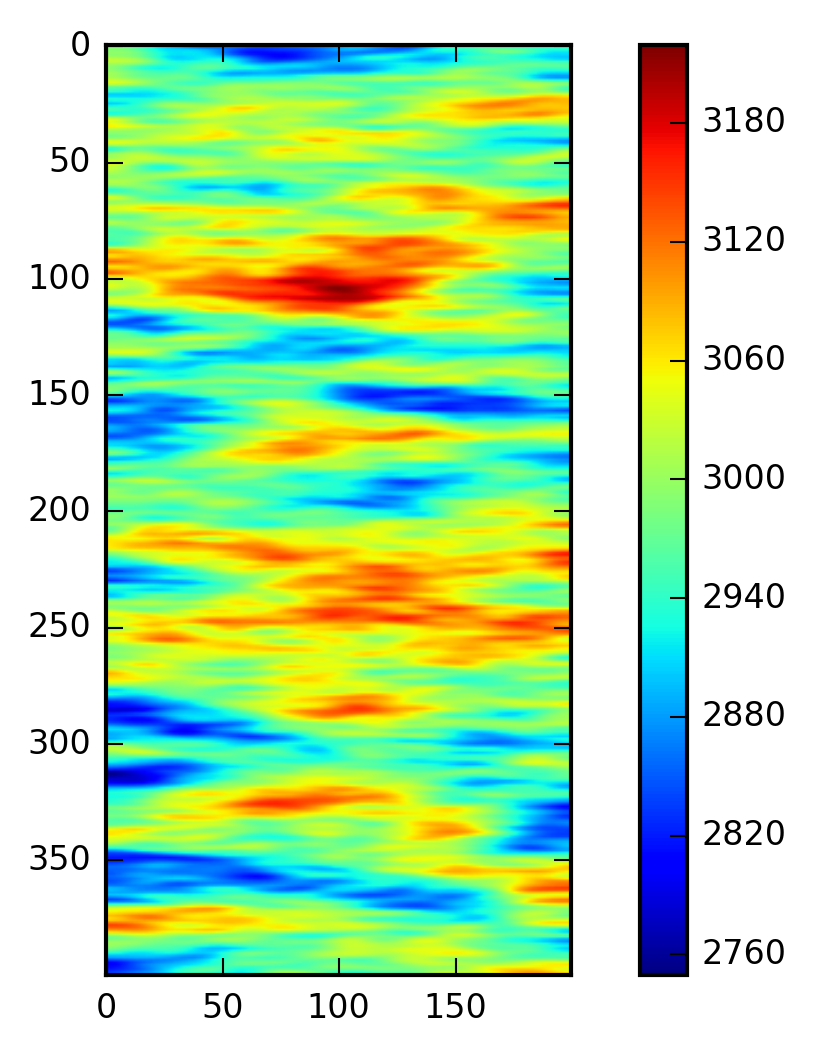

In [9]:
plt.imshow(cTrue.T)
plt.colorbar()

Parameters not set in *.ini* file:

In [10]:
freeSurf    = [False, False, False, False] # t r b l
nPML        = 10            # number of PML points
density     = 2700          # units of density
Q           = 20            # can be inf

cache       = False         # whether to cache computed wavefields for a given source
cacheDir    = '.'

parFac = 1
chunksPerWorker = 1        # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = True

In [11]:
rho         = np.ones(cTrue.shape) * density

if geom2D:
    geom        = {
        'src':  np.array([ini['srcs'][:,0], np.zeros(ini['ns']), ini['srcs'][:,1]]).T,
        'rec':  np.array([ini['recs'][:,0], np.zeros(ini['nr']), ini['recs'][:,1]]).T,
        'mode': 'fixed',
    }
else:
    geom        = {
        'src':  ini['srcs'],
        'rec':  ini['recs'],
        'mode': 'fixed',
    }

# geom['src'] = geom['src'][:10]

systemConfig = {
    'dx':       ini['dx'],  # m
    'dz':       ini['dz'],  # m
    'c':        cTrue.T,    # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       ini['nx'],         # count
    'nz':       ini['nz'],         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    ini['freqs'],
    'nky':      ini['nky'],
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
}

In [12]:
%%time
problem = SeisFDFD25DParallelProblem(systemConfig)
survey = SeisFDFD25DSurvey(geom)
survey.pair(problem)

CPU times: user 162 ms, sys: 23 ms, total: 185 ms
Wall time: 643 ms


In [13]:
problem.forward()

In [14]:
problem.forwardGraph

In [15]:
problem.forwardGraph.node['Compute: 1, 0, 0'].get('jobs', [])[0].get()

In [16]:
dObs = problem.dPred
problem.dObs = dObs

Plotting 'true' wavefield for one source:

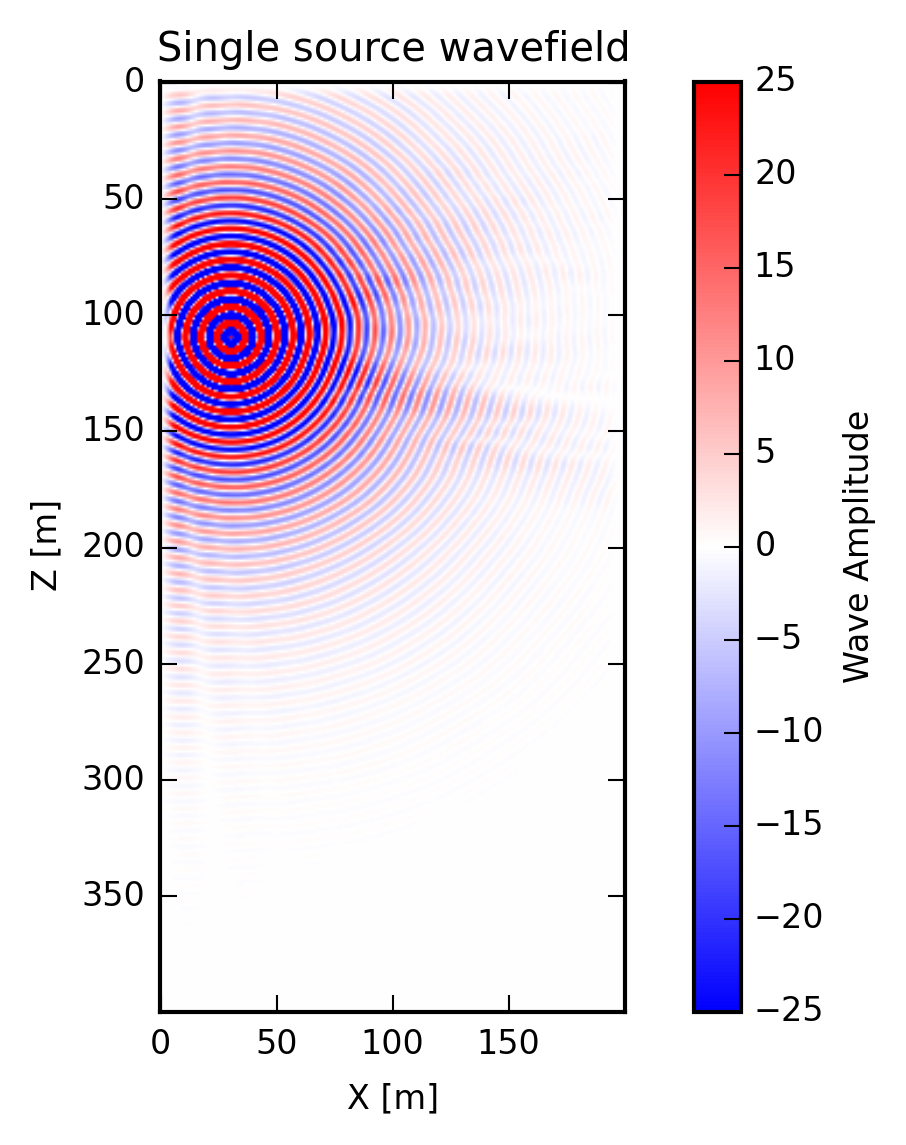

In [17]:
clip = 0.25e2
plt.imshow(problem.remote.e0['endpoint.globalFields[\'fWave\'][2][40]'].reshape(cFlat.T.shape).real, cmap=cm.bwr, vmin=-clip, vmax=clip)
cb = plt.colorbar(orientation='vertical')
plt.title('Single source wavefield')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
cb.ax.set_ylabel('Wave Amplitude')

In [18]:
problem.rebuildSystem(cFlat.T)
problem.forward()
uF = problem.uF
problem._computeResidual()
# uF = problem.remote.e0['endpoint.globalFields[\'fWave\'][2][40]'].reshape(cFlat.T.shape)
problem.backprop()
uB = problem.uB

In [19]:
import inversion
sim = inversion.SeisInverseProblem(problem, cFlat.T)
sim._preScaleFreqs = {key: 1. for key in xrange(8)}

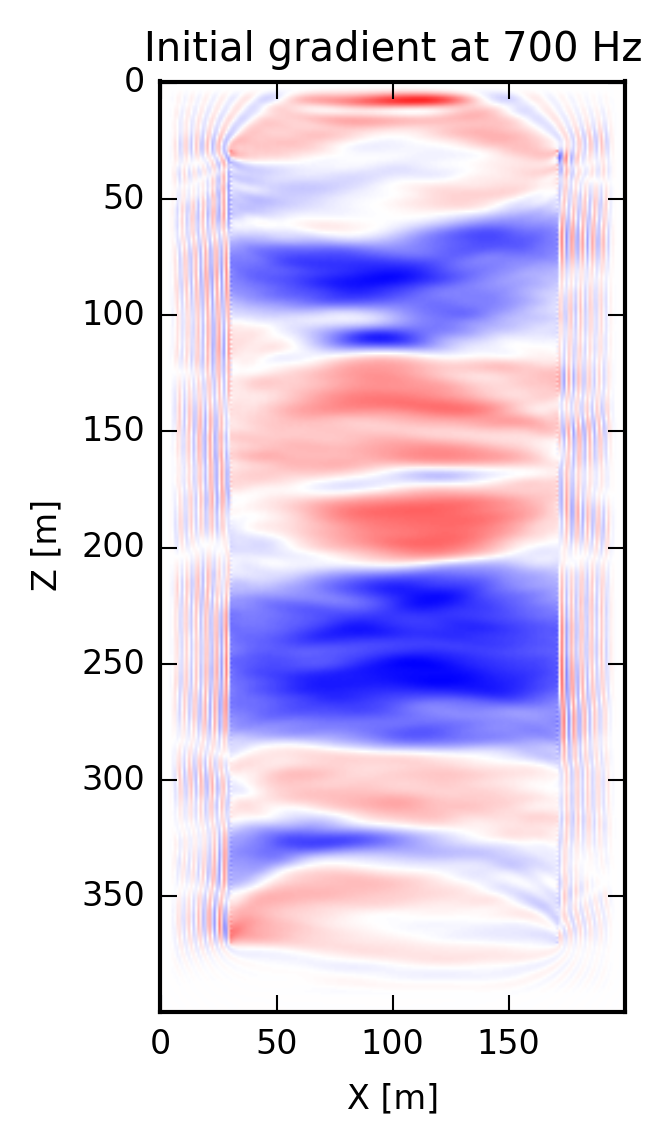

In [20]:
g0 = problem.g[0].reshape(cFlat.T.shape).real
g0 = g0 / abs(g0).max()
# plt.imshow(sim.g(sim.x0).reshape(cFlat.T.shape), cmap=cm.bwr)
plt.imshow(g0, cmap=cm.bwr, vmin=-1, vmax=1)
# cb = plt.colorbar(orientation='vertical')
plt.title('Initial gradient at 700 Hz')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
# cb.ax.set_ylabel('Sensitivity')

Inverting using new `inversion` wrapper, and canned solver (`fmin_cg`, `fmin_l_bfgs_b`, or `fmin_ncg`)

In [21]:
%%time
import inversion
reload(inversion)
sim = inversion.SeisInverseProblem(problem, cFlat.T)
res = sim(solver=inversion.fmin_l_bfgs_b, maxiter=10)

It.	Misfit		fn Eval.
			2.35e+03
  0	2.35e+03
			2.39e+03
			2.40e+03
			2.34e+03
			2.34e+03
			2.39e+03
			2.34e+03
			2.34e+03
			2.40e+03
			2.34e+03
			2.34e+03
			2.40e+03
			2.34e+03
			2.34e+03
			2.49e+03
			2.34e+03
			2.34e+03
			2.16e+03
  1	2.16e+03
			1.73e+03
  2	1.73e+03
			1.56e+03
  3	1.56e+03
			1.29e+03
  4	1.29e+03
			1.07e+03
  5	1.07e+03
			8.31e+02
  6	8.31e+02
			6.72e+02
  7	6.72e+02
			5.24e+02
  8	5.24e+02
			4.45e+02
  9	4.45e+02
			3.86e+02
 10	3.86e+02
			3.35e+02
 11	3.35e+02
			2.84e+02
CPU times: user 4min 9s, sys: 49.1 s, total: 4min 58s
Wall time: 36min 21s


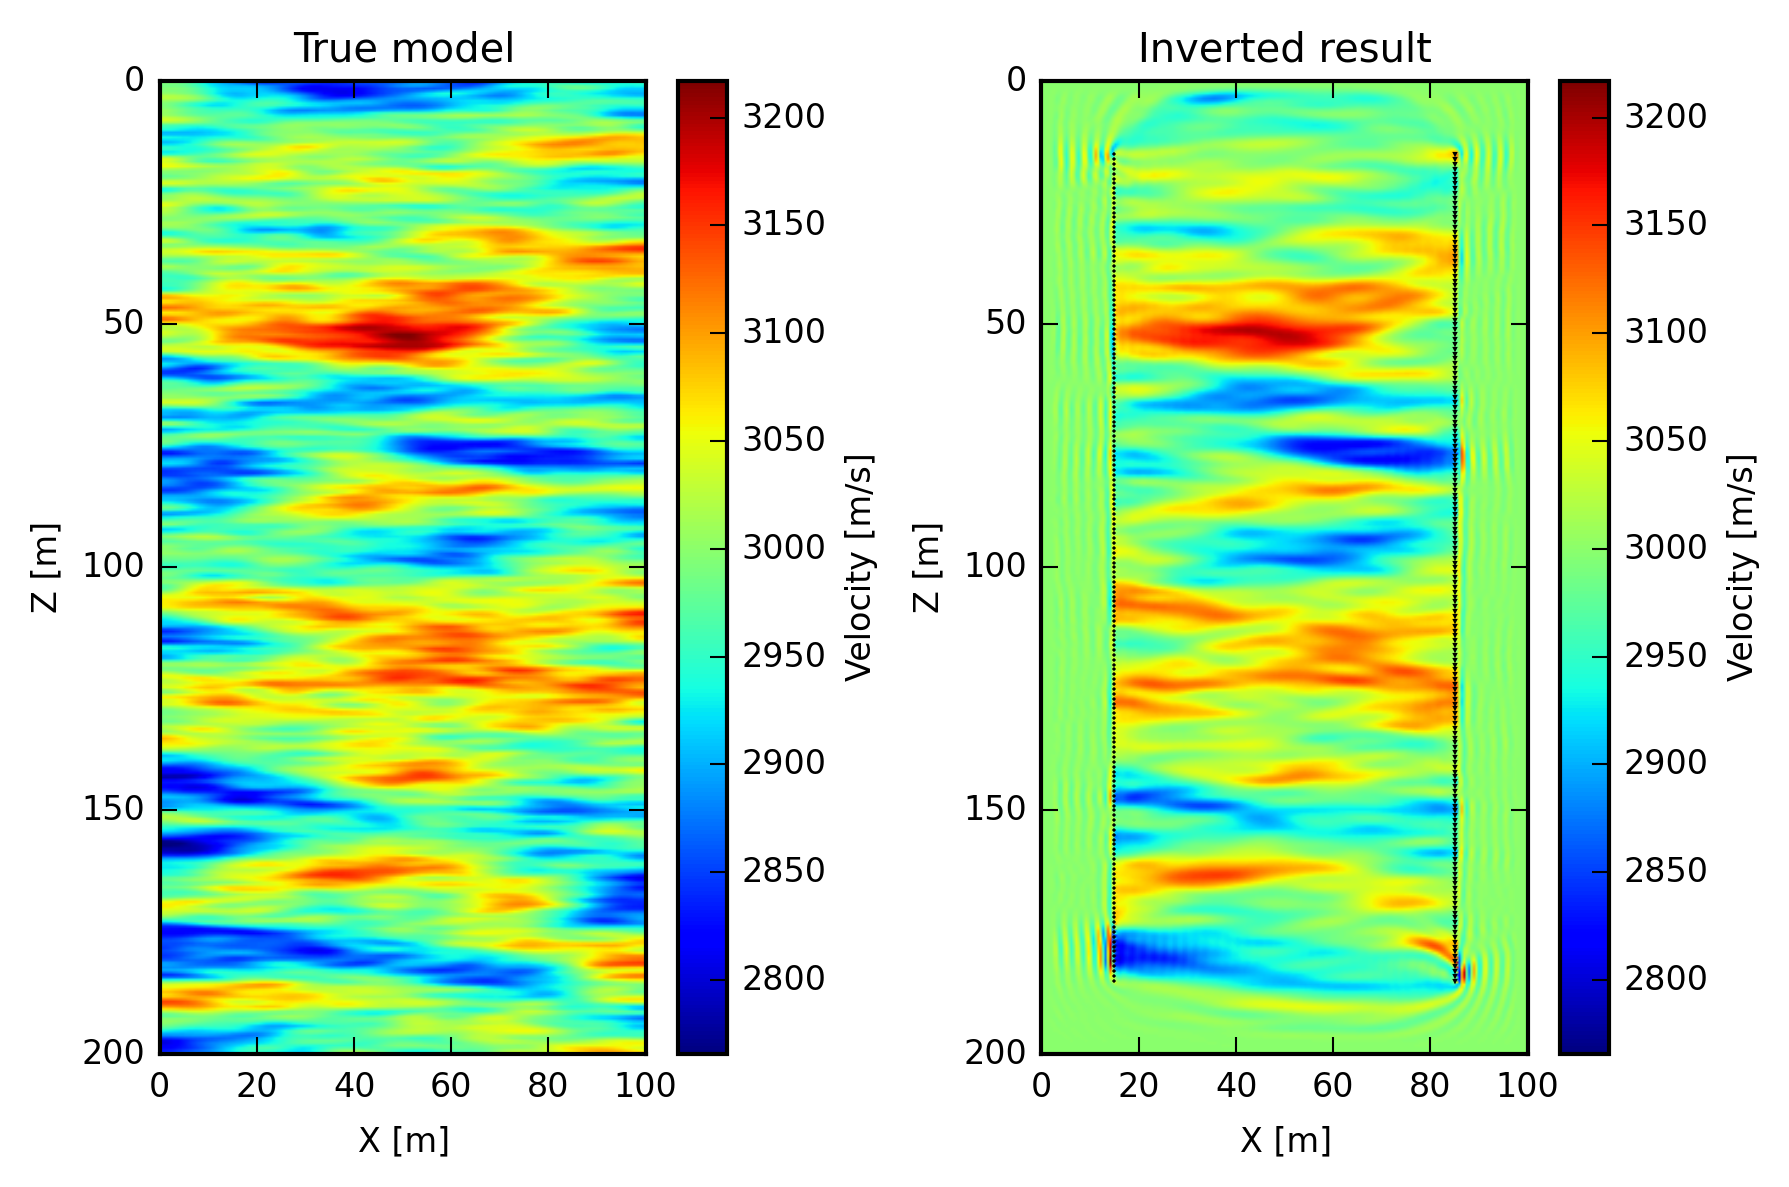

In [22]:
vel = 1./(res[0] if type(res) is tuple else res).reshape(cTrue.T.shape)
x0 = ini['xorig']
x1 = ini['xorig'] + ini['nx'] * ini['dx']
z0 = ini['zorig']
z1 = ini['zorig'] + ini['nz'] * ini['dz']

plotopts = {
    'extent':   [x0, x1, z1, z0],
    'cmap':     cm.jet,
    'vmin':     vel.min(),
    'vmax':     vel.max(),
}

fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(cTrue.T, **plotopts)
cb = plt.colorbar(orientation='vertical')
plt.title('True model')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
cb.ax.set_ylabel('Velocity [m/s]')

plt.subplot(1,2,2)
plt.imshow(vel, **plotopts)
cb = plt.colorbar(orientation='vertical')
plt.title('Inverted result')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
cb.ax.set_ylabel('Velocity [m/s]')
plt.plot(geom['src'][:,0], geom['src'][:,2], 'kx', markersize=0.5)
plt.plot(geom['rec'][:,0], geom['rec'][:,2], 'kv', markersize=0.5)

fig.tight_layout()

Note that at +/- 2500 a cycle skip appears.